# Proyek Klasifikasi Gambar: Wayang
- **Nama:** Rizki Rahman Maulana
- **Email:** mc253d5y0335@student.devacademy.id
- **ID Dicoding:** ikirahman

## Import Semua Packages/Library yang Digunakan

## Data Preparation

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import shutil
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools
import random
from google.colab import drive
from google.colab import files


### Data Loading

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

local_zip = '/content/drive/MyDrive/Dataset/wayang.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/wayang')
zip_ref.close()


### Data Preprocessing

#### Split Dataset

In [4]:
# Path asli dataset
original_dataset_dir = '/content/wayang/labeled-indonesian-wayang'

# Path baru setelah split
base_dir = '/content/wayang_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Membuat direktori
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Dapatkan semua class (folder di /wayang)
classes = os.listdir(original_dataset_dir)

# Loop untuk semua class
for class_name in classes:
    class_path = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_path):
        # Buat subfolder untuk setiap class
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Ambil semua file gambar dalam class
        images = os.listdir(class_path)
        random.shuffle(images)

        # Hitung jumlah data
        total_images = len(images)
        train_split = int(0.7 * total_images)
        validation_split = int(0.2 * total_images)

        # Copy gambar ke masing-masing folder
        for idx, image_name in enumerate(images):
            src_path = os.path.join(class_path, image_name)

            if idx < train_split:
                dst_path = os.path.join(train_dir, class_name, image_name)
            elif idx < train_split + validation_split:
                dst_path = os.path.join(validation_dir, class_name, image_name)
            else:
                dst_path = os.path.join(test_dir, class_name, image_name)

            shutil.copy2(src_path, dst_path)

print("Dataset berhasil di-split 70% Train, 20% Validation, 10% Test! 🚀")

Dataset berhasil di-split 70% Train, 20% Validation, 10% Test! 🚀


## Modelling

In [5]:
# ImageDataGenerator untuk augmentasi pada training set
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi pixel 0-255 jadi 0-1
    rotation_range=10,           # Rotasi acak
    width_shift_range=0.2,       # Geser lebar
    height_shift_range=0.2,      # Geser tinggi
    shear_range=0.2,             # Shear
    zoom_range=0.2,              # Zoom
    vertical_flip=True,          # Flip vertikal
)

# Untuk validation dan test, cukup rescale saja
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),       # Resize ke 150x150
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False                # Penting saat evaluasi
)


Found 6412 images belonging to 22 classes.
Found 3209 images belonging to 22 classes.
Found 1801 images belonging to 22 classes.


In [6]:
# Model Sequential dengan tambahan BatchNormalization dan penambahan unit di Dense layer
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │        11,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,824,662 (26.03 MB)

 Trainable params: 6,823,702 (26.03 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

In [8]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 93s 413ms/step - accuracy: 0.1025 - loss: 3.6479 - val_accuracy: 0.0570 - val_loss: 4.7704 - learning_rate: 1.0000e-04
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 74s 371ms/step - accuracy: 0.1935 - loss: 2.7643 - val_accuracy: 0.1745 - val_loss: 3.0238 - learning_rate: 1.0000e-04
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 76s 376ms/step - accuracy: 0.2442 - loss: 2.5381 - val_accuracy: 0.3730 - val_loss: 2.0658 - learning_rate: 1.0000e-04
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.3174 - loss: 2.2945 - val_accuracy: 0.3406 - val_loss: 2.2592 - learning_rate: 1.0000e-04
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 76s 381ms/step - accuracy: 0.3618 - loss: 2.1016 - val_accuracy: 0.4145 - val_loss: 1.9118 - learning_rate: 1.0000e-04
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 75s 371ms/step - accuracy: 0.4104 - loss: 1.9124 - val_accuracy: 0.4818 - val_loss: 1.6603 - learning_rate: 1.0000e-04
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 83s 41

## Evaluasi dan Visualisasi

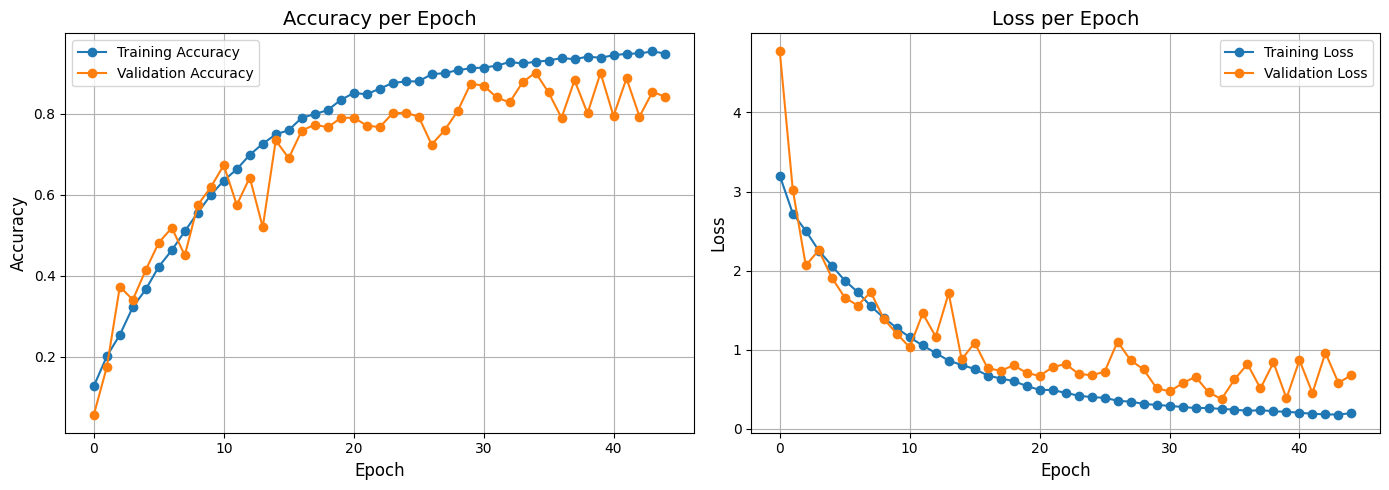

In [9]:
# Buat plot akurasi
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Konversi Model

In [11]:
export_dir = 'exports'
saved_model_dir = os.path.join(export_dir, 'saved_model')
tflite_model_path = os.path.join(export_dir, 'model.tflite')

if os.path.exists(export_dir):
    shutil.rmtree(export_dir)
os.makedirs(saved_model_dir, exist_ok=True)

# 1. Save model menggunakan tf.saved_model.save untuk SavedModel
tf.saved_model.save(model, saved_model_dir)
print(f"✅ Model berhasil disimpan dalam format SavedModel di: {saved_model_dir}")

# 2. Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"✅ Model berhasil dikonversi ke TFLite dan disimpan di: {tflite_model_path}")

print("\n🚀 SavedModel dan TFLite sukses! Siap ke TFJS kalau mau lanjut!")

✅ Model berhasil disimpan dalam format SavedModel di: exports/saved_model
✅ Model berhasil dikonversi ke TFLite dan disimpan di: exports/model.tflite

🚀 SavedModel dan TFLite sukses! Siap ke TFJS kalau mau lanjut!


In [15]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model exports/saved_model exports/tfjs_model

2025-04-27 04:36:31.496063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745728591.559172   41056 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745728591.569634   41056 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-27 04:36:41.094741: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745728601.094914   41056 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

### Inference SavedModel

In [33]:
loaded_model = tf.saved_model.load('exports/saved_model')
infer = loaded_model.signatures["serving_default"]

image_path = '/content/wayang_split/test/anoman/anoman002b.jpg'
img = Image.open(image_path).resize((150, 150))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

img_array = img_array.astype(np.float32)

predictions = infer(tf.constant(img_array))

probabilities = predictions['output_0'].numpy()[0]

class_names = list(train_generator.class_indices.keys())

for i, probability in enumerate(probabilities):
    print(f"{class_names[i]}: {probability * 100:.2f}%")

predicted_class_index = np.argmax(probabilities)
predicted_class_name = class_names[predicted_class_index]

print(f"\nPredicted class: {predicted_class_name}")

abimanyu: 0.00%
anoman: 99.99%
arjuna: 0.00%
bagong: 0.00%
baladewa: 0.00%
bima: 0.00%
buta: 0.00%
cakil: 0.00%
durna: 0.00%
dursasana: 0.00%
duryudana: 0.00%
gareng: 0.00%
gatotkaca: 0.00%
karna: 0.00%
kresna: 0.00%
nakula_sadewa: 0.00%
patih_sabrang: 0.00%
petruk: 0.00%
puntadewa: 0.00%
semar: 0.00%
sengkuni: 0.00%
togog: 0.00%

Predicted class: anoman


In [40]:
def preprocess_image(uploaded_file):
    try:
        image = Image.open(uploaded_file).convert('RGB').resize((150, 150))
        img_array = np.array(image) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array.astype(np.float32)
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    image_array = preprocess_image(fn)

    if image_array is not None:
        predictions = infer(tf.constant(image_array))
        probabilities = predictions['output_0'].numpy()[0]

        class_names = list(train_generator.class_indices.keys())

        for i, probability in enumerate(probabilities):
            print(f"{class_names[i]}: {probability * 100:.2f}%")

        predicted_class_index = np.argmax(probabilities)
        predicted_class_name = class_names[predicted_class_index]

        print(f"\nPredicted class: {predicted_class_name}")


Saving sengkuni11.jpg to sengkuni11 (1).jpg
Saving anoman.jpg to anoman (2).jpg
Saving arjuna.jpg to arjuna (2).jpg
Saving petruk.jpg to petruk (3).jpg
Saving kresna.jpg to kresna (3).jpg
Saving abimanyu_ky.jpg to abimanyu_ky (4).jpg
User uploaded file "sengkuni11 (1).jpg" with length 35793 bytes
abimanyu: 0.00%
anoman: 0.00%
arjuna: 0.00%
bagong: 0.00%
baladewa: 0.00%
bima: 0.00%
buta: 0.00%
cakil: 0.00%
durna: 0.00%
dursasana: 0.00%
duryudana: 0.00%
gareng: 0.00%
gatotkaca: 0.00%
karna: 0.00%
kresna: 0.00%
nakula_sadewa: 0.00%
patih_sabrang: 0.00%
petruk: 0.00%
puntadewa: 0.00%
semar: 0.00%
sengkuni: 100.00%
togog: 0.00%

Predicted class: sengkuni
User uploaded file "anoman (2).jpg" with length 67937 bytes
abimanyu: 0.00%
anoman: 100.00%
arjuna: 0.00%
bagong: 0.00%
baladewa: 0.00%
bima: 0.00%
buta: 0.00%
cakil: 0.00%
durna: 0.00%
dursasana: 0.00%
duryudana: 0.00%
gareng: 0.00%
gatotkaca: 0.00%
karna: 0.00%
kresna: 0.00%
nakula_sadewa: 0.00%
patih_sabrang: 0.00%
petruk: 0.00%
puntadew